# Robot de Almacén

### Datos a considerar
- La semilla para generación de números aleatorios será 67890.
- El almacén es 20x20 celdas.
- Al inicio de la simulación, tu solución deberá colocar 200 cajas repartidas en grupos de 1 a 3 cajas en posiciones aleatorias.
- Todos los robots empiezan en posiciones aleatorias vacías. Y, sólo puede haber un robot por celda.
- La simulación termina cuando todas las cajas se encuentra apiladas en pilas de exactamente 5 cajas.


### Resultados
-	Descripción detallada de la estrategia y los mecanismos utilizados en tu solución.
-	Una visualización que permita ver los diferentes pasos de la simulación.
-	El número de pasos necesarios para terminar la simulación.
-	¿Existe una forma de reducir el número de pasos utilizados? Si es así, ¿cuál es la estrategia que se tendría en implementar?


### Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd
import random

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [2]:
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.id = id
        self.has_box = False
        self.target = None
        self.found_boxes = np.zeros((model.grid.width, model.grid.height), dtype=int)
        self.boxes = 0

    def step(self):
        """
        Función que ejecuta el comportamiento del robot en cada paso de la simulación.
        """
        self.stop()

        possible_cells = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center = False)

        if self.target:
            self.move_to_target()
            return

        self.analyze(possible_cells)
        self.move(possible_cells)

    def stop(self):
        """
        Función que detiene la simulación cuando el robot ha encontrado todas las cajas.
        """
        us = self.find_uncompleted_stacks()
        found_boxes_quantity = np.count_nonzero(self.found_boxes)
        total_boxes_quantity = np.count_nonzero(self.model.boxes)

        if (us == [] and found_boxes_quantity == total_boxes_quantity):
            print("Robot " + str(self.id) + " ha apilado todas las cajas")
            self.model.running = False

    def move(self, possible_cells):
        """
        Función que mueve al robot a una celda aleatoria.
        """
        new_position = random.choice(possible_cells)

        possible_movs = 4
        while(self.model.boxes[new_position] > 0):
            new_position = random.choice(possible_cells)
            possible_movs -= 1
            if (possible_movs == 0):
                return

        self.model.grid.move_agent(self, new_position)
        self.pos = new_position

    def analyze(self, possible_cells):
        """
        Función que busca cajas en las celdas vecinas y las recoge o deja
        según el número de cajas que haya en la celda.
        """
        for cell in possible_cells:
            if self.model.boxes[cell] > 0:
                self.found_boxes[cell] = self.model.boxes[cell]
                if self.has_box and self.model.boxes[cell] < 5:
                    self.stack_box(cell)
                elif not self.has_box and self.model.boxes[cell] < 3:
                    self.pick_box(cell)
                    us = self.find_uncompleted_stacks()
                    if us != [] and self.target == None:
                        self.target = random.choice(us)


    def pick_box(self, cell):
        """
        Función que recoge una caja de una celda y actualiza los valores de
        las cajas en el modelo.
        """
        self.has_box = True
        self.model.boxes[cell] -= 1
        self.found_boxes[cell] -= 1

    def stack_box(self, cell):
        """
        Función que deja una caja en una celda y actualiza los valores de las cajas en el modelo.
        """
        self.has_box = False
        self.model.boxes[cell] += 1
        self.found_boxes[cell] += 1

    def find_uncompleted_stacks(self):
        """
        Función que calcula el número de cajas que el robot ha recogido.
        """
        unstacked_boxes = []
        for x in range(self.model.grid.width):
            for y in range(self.model.grid.height):
                if self.found_boxes[x][y] < 4 and self.found_boxes[x][y] > 2:
                    unstacked_boxes.append((x,y))
        return unstacked_boxes

    def move_to_target(self):
        """
        Función que mueve al robot a la celda objetivo un paso más cerca por cada paso de la simulación.
        """
        neighbor_cells = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center = False)

        if self.target in neighbor_cells:
            self.stack_box(self.target)
            self.target = None
            return

        new_position = ()
        if self.pos[0] < self.target[0]:
            new_position = (self.pos[0] + 1, self.pos[1])
        elif self.pos[0] > self.target[0]:
            new_position = (self.pos[0] - 1, self.pos[1])
        elif self.pos[1] < self.target[1]:
            new_position = (self.pos[0], self.pos[1] + 1)
        elif self.pos[1] > self.target[1]:
            new_position = (self.pos[0], self.pos[1] - 1)

        self.model.grid.move_agent(self, new_position)
        self.pos = new_position

In [3]:
def get_robots(model):
    return np.asarray([agent.pos for agent in model.schedule.agents])

In [4]:
def get_boxes(model):
    return model.boxes

In [5]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, torus=False)
        self.boxes = np.zeros((width, height), dtype=int)
        self.datacollector = DataCollector(model_reporters={"Robot": get_robots, "Boxes": get_boxes})
        self.running = True

        init_boxes = 0
        while init_boxes < num_boxes:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if self.boxes[x, y] < 3:
              self.boxes[x, y] += 1
              init_boxes += 1

        agent_pos = []
        while len(agent_pos) < num_agents:
            x, y = np.random.randint(0, width), np.random.randint(0, height)
            if (x, y) not in agent_pos and self.boxes[x, y] == 0:
                agent = RobotAgent(len(agent_pos), self)
                self.schedule.add(agent)
                self.grid.place_agent(agent, (x, y))
                agent_pos.append((x, y))

        print(f"Initial boxes: \n{self.boxes}")

    def step(self):
         if self.running == False:
             return

         self.datacollector.collect(self)
         self.schedule.step()

In [6]:
WIDTH = 20
HEIGHT = 20
ROBOTS = 1
ITERATIONS = 50000
MAX_BOXES = 200
SEED = 67890
random.seed(SEED)

In [7]:
model = WarehouseModel(WIDTH, HEIGHT, ROBOTS, MAX_BOXES)
steps = 0
while (model.running):
    model.step()
    steps += 1
    if (steps == ITERATIONS):
        break

print(f"Steps: {steps}")

Initial boxes: 
[[0 1 0 0 0 0 1 1 0 0 0 2 0 1 0 0 1 1 1 0]
 [0 0 2 0 0 2 2 1 1 0 0 1 0 0 0 0 1 1 0 3]
 [1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 2 1 0 1 2 1 2 0 0 1 2 0 1 1 0 0]
 [0 1 1 0 2 0 1 0 0 0 1 2 0 0 0 0 2 0 1 0]
 [2 0 1 0 0 0 3 0 0 0 0 1 2 0 0 1 1 1 0 0]
 [0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 2 0]
 [0 0 1 1 1 0 0 1 0 0 1 2 0 3 0 1 0 0 1 0]
 [0 0 0 2 0 2 0 0 1 1 0 0 1 0 0 1 1 0 2 0]
 [0 0 0 2 0 0 0 1 0 0 0 0 0 1 1 2 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 3 0 0 2 2 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1]
 [0 0 0 0 1 1 1 1 0 1 0 1 2 1 1 0 0 0 0 0]
 [0 1 1 0 1 0 1 0 0 2 0 0 0 0 2 1 0 0 1 0]
 [0 1 0 0 0 1 0 2 1 3 0 1 0 0 0 0 0 0 0 1]
 [1 0 2 0 0 1 1 0 1 0 0 1 1 2 0 1 0 0 0 1]
 [0 0 1 1 0 0 1 0 0 1 0 1 0 2 2 2 0 0 0 1]
 [1 1 0 2 0 0 1 0 0 0 0 0 2 0 0 1 1 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 2 0 1]
 [1 0 0 0 1 1 0 0 1 0 0 2 1 0 0 0 2 0 0 0]]
Robot 0 ha apilado todas las cajas
Steps: 2942


In [8]:
for agent in model.schedule.agents:
    print(f"Robot {agent.id} found {sum(sum(agent.found_boxes))} boxes in positions \n {agent.found_boxes}")
    if agent.has_box:
        print(f"Robot {agent.id} has a box")
    unstacked_boxes = np.where(agent.found_boxes < 5, agent.found_boxes, 0)
    print("Unstacked boxes: \n", unstacked_boxes)
    # return np.count_nonzero(unstacked_boxes)

Robot 0 found 206 boxes in positions 
 [[0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 5 0 5 0 0 0 0 0 0 0 0 5 0 0 5]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 5 0 5 0 0 4 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [5 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 5 5 0 5 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 2 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 5 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 2 0 0 0]]
Robot 0 has a box
Unstacked boxes: 
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 

In [9]:
all_positions = model.datacollector.get_model_vars_dataframe()

C:\Users\sgarn\AppData\Local\Temp\ipykernel_28128\2148707644.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
C:\Users\sgarn\AppData\Local\Temp\ipykernel_28128\2148707644.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scatter.set_offsets(all_positions.iloc[i][0])


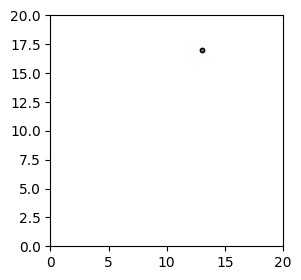

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], s=10, edgecolor="k")
ax.axis([0, WIDTH, 0, HEIGHT])

def animate(i):
    scatter.set_offsets(all_positions.iloc[i][0])
    return scatter

anim = animation.FuncAnimation(fig, animate, frames = ITERATIONS)

In [11]:
# anim

C:\Users\sgarn\AppData\Local\Temp\ipykernel_28128\536203090.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  box_positions = all_positions.iloc[0][1]


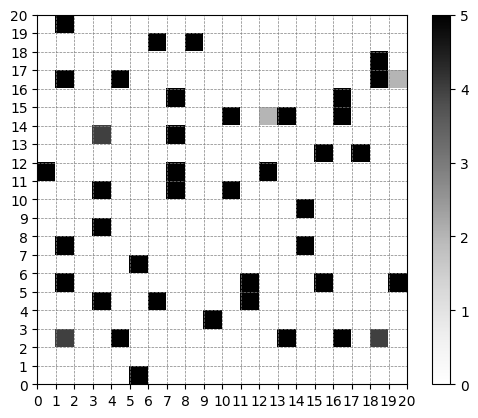

In [12]:
box_positions = all_positions.iloc[0][1]
box_counts = np.zeros((WIDTH, HEIGHT), dtype=int)
for x in range(model.grid.width):
    for y in range(model.grid.height):
      box_counts[y][x] = box_positions[x][y]

cmap = plt.cm.Greys

plt.imshow(box_counts, cmap=cmap, interpolation='nearest', origin="lower", extent=[0, HEIGHT, 0, WIDTH])
plt.colorbar()

# Set ticks for both axes
plt.xticks(np.arange(0, HEIGHT+1, 1))
plt.yticks(np.arange(0, WIDTH+1, 1))

# Add grid lines
plt.grid(color='gray', linestyle='--', linewidth=0.5)